## Imports
Importing all required modules

In [2]:
from random import random, choice, randint, shuffle, sample, uniform # random integers and random shuffling of a list
from itertools import permutations # iterate over all possible permutations of a list
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt, log, factorial  # square root, logarithm, and n!
from time import perf_counter # for measuring time. NB. 'perf_counter' is better/more accurate than 'time'
import networkx as nx # to draw sample graphs
import pandas as pd # to show the adjacency matrix in a nice format
import matplotlib.pyplot as plt # to plot graphs of time and quality vs n
import seaborn as sns # nice statistical plots -- see e.g. https://seaborn.pydata.org/tutorial/relational.html#relational-tutorial
sns.set_style("white")

## Defining a Graph
Graph class for creating graphs to use with algorithms. All graphs are complete and weighted.

Supports 4 types of graphs:
- `asymmetric`: Directed graph with random weights
- `symmetric`: Undirected graph with random weights
- `easy`: All edges have the weight 2, except for a cycle which has edges with the weight 1
- `Euclidean`: Vertices placed on a 2D coordinate plane and the weight of the edges is the Euclidean distance between them

Examples:
- Creating a Euclidean graph with 10 vertices: `G = Graph(10, 'Euclidean')`
- Getting the number of vertices: `G.n`
- Getting the weight of the edge from $a$ to $b$: `G[a][b]`

In [3]:
class Graph:
    """ Random graphs """
    def __init__(self, n=0, type="asymmetric", MAX_WEIGHT=100, MAX_X=200, MAX_Y=200):
        self.n = n
        self.vertices = list(range(n)) # [0,1,...,n-1]
        self.type = type
        self.adj_matrix = [[oo for i in range(n)] for j in range(n)]
        # Generate a random adjacency matrix according to the required type
        if type == "symmetric": self.__random_symmetric_graph(n, MAX_WEIGHT)
        elif type == "Euclidean": self.__random_euclidean_graph(n, MAX_X,MAX_Y)
        elif type == "easy": self.__random_cycle_graph(n)
        else: self.__random_asymmetric_graph(n, MAX_WEIGHT) # assume "asymmetric" otherwise
            
    def __getitem__(self, i):
        """ Allow indexing to get the weights """
        return self.adj_matrix[i]
                
    def __random_asymmetric_graph(self, n, MAX_WEIGHT):
        """ Asymmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(n):
                if i == j: continue # no self-loops
                self.adj_matrix[i][j] = randint(1, MAX_WEIGHT)

    def __random_symmetric_graph(self, n, MAX_WEIGHT):
        """ Symmetric adjacency matrix of size nxn """
        for i in range(n):
            for j in range(i + 1, n):
                w = randint(1, MAX_WEIGHT)
                self.adj_matrix[i][j] = w
                self.adj_matrix[j][i] = w

    def __random_cycle_graph(self,n):
        """ Symmetric adjacency matrix of size nxn with one reandomly chosen cycle
        All the edge weights are 2 except for the cycle (weight=1) """
        self.adj_matrix = [[2 for _ in range(n)] for _ in range(n)] # All weights=2
        # Select a random cycle which will have weight=1
        cycle = list(range(1, n)) # don't include 0 as we want to be at the start
        shuffle(cycle) # in-place random permutation
        cycle = [0]+cycle+[0] # cycle starting and ending at 0
        for a, b in zip(cycle, cycle[1:]): # set the cycle's weights to 1
            self.adj_matrix[a][b] = 1
            self.adj_matrix[b][a] = 1

    def __random_euclidean_graph(self, n, MAX_X, MAX_Y):
        """ Symmetric adjacency matrix of a Euclidean graph of size nxn """
        # (1/2) Generate random (x,y) points
        points = set()
        while len(points) < n: # We may get duplicate (x,y) so we try until we get enough points
            x, y = randint(0, MAX_X), randint(0, MAX_Y)
            points.add((x, y))
        points = list(points) # Sets are not indexed, so convert into a list
        # (2/2) Now compute the adjacency matrix
        for i in range(n):
            p1 = points[i]
            for j in range(i+1, n):
                p2 = points[j]
                distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
                self.adj_matrix[i][j] = distance
                self.adj_matrix[j][i] = distance
        self.points = points

### Utility functions on the Graph

- **cost(Graph, cycle)**: Calculates the cost of a cycle in the graph (The first and last elements need to be the same in the cycle).
- **show(Graph)**: Displays the adjacency matrix of the graph.
- **draw(Graph, path?)**: Draws the graph. If a path is specified, only draws the edges in the path. The weight of the edges is not shown for graphs that have more than 15 vertices.

In [4]:
def cost(G, cycle):
    """ Calculate the cost of the given cycle [0,...,0] in G """
    return sum(G[a][b] for a, b in zip(cycle, cycle[1:]))

In [5]:
def show(G):
    ''' Show adjacency matrix. Useful for debugging.
    'type' is a string from: Euclidean, Cycle, ...
    The distances are round to 1 decimal point for clarity/simplicity
    '''
    print(f"{G.n}x{G.n} {G.type} graph:")
    if G.type=='Euclidean': print("Points:",G.points)
    r = pd.DataFrame({str(i): G[i] for i in range(G.n)})
    display(r)
    
def nx_graph(G, path=None):
    ''' Convert G into NetworkX format '''
    nxG = nx.Graph() if G.type!='asymmetric' else nx.DiGraph() # undirected/directed graph
    nxG.add_nodes_from(G.vertices) # Add the vertices
    # Now add the edges
    if path is None:
        # If no specific path is given - Add all edges
        for a in G.vertices:
            for b in G.vertices:
                if a==b: continue # no self-loops
                nxG.add_edge(a, b, weight=G[a][b])
    else:
        # If path is given - Add only edges specified in path
        for i in range(len(path) - 1):
            a = path[i]
            b = path[i + 1]
            nxG.add_edge(a, b, weight=G[a][b])
        # Add last edge
        a = path[-1]
        b = path[0]
        nxG.add_edge(a, b, weight=G[a][b])
    if G.type=='Euclidean': # add (x,y) coordinates if available
        pos=dict(enumerate(G.points)) # vertex:(x,y) pairs
        nx.set_node_attributes(nxG, pos, 'coord')
    return nxG

def draw(G, path=None, weight_tags=False):
    ''' Draw the graph G using NetworkX '''
    nxG = nx_graph(G, path)
    weights_dictionary = nx.get_edge_attributes(nxG,'weight')
    edges,weights = zip(*weights_dictionary.items())
    pos = nx.circular_layout(nxG) if G.type!='Euclidean' else nx.get_node_attributes(nxG,'coord')
    nx.draw(nxG, pos, \
            with_labels=True, node_color='red', font_color='white', font_weight='bold', font_size=14,\
            edge_color=weights, width=1.5, connectionstyle="arc3,rad=0.1", edge_cmap=plt.cm.copper)
    # see https://matplotlib.org/stable/gallery/color/colormap_reference.html
    if weight_tags:
        nx.draw_networkx_edge_labels(nxG, pos, edge_labels=weights_dictionary)

Example

8x8 euclidean graph:


,0,1,2,3,4,5,6,7
0,inf,36.0,52.0,85.0,94.0,37.0,23.0,46.0
1,53.0,inf,99.0,75.0,57.0,44.0,46.0,100.0
2,82.0,75.0,inf,26.0,74.0,78.0,45.0,75.0
3,31.0,54.0,22.0,inf,80.0,30.0,40.0,24.0
4,54.0,8.0,39.0,3.0,inf,1.0,28.0,67.0
5,22.0,5.0,31.0,56.0,17.0,inf,12.0,83.0
6,79.0,13.0,39.0,21.0,60.0,38.0,inf,1.0
7,89.0,62.0,28.0,75.0,15.0,7.0,91.0,inf


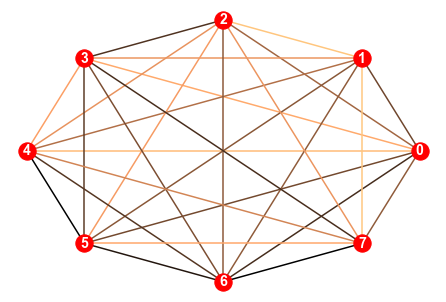

In [6]:
G = Graph(8,"euclidean")
show(G)
draw(G)

# Genetic Algorithm - Chromosome approach

Genetic algorithms are a subset of evolutionary algorithms. Inspired by the biological process of natural selection, genetic algorithms use biologically inspired operators such as chromosomes, mutation, crossover, and selection.

## Definitions
* **Gene** - A city represented by co-ordinates e.g. (x, y)
* **Chromosome** - A route that satisfies the rules for the TSP e.g. [1, 2, 3]
* **Population** - A collection of chromosomes e.g. [[1, 2, 3], [3, 2, 1]]
* **Parents** - Product of two combined chromosomes e.g.
* **Mating pool** - Collection of parents used to build next generation
* **Mutation** - Method to introduce variation via randomly swapping two genes in a chromosome 

**To summarise the algorithm used in this approach**:
1. Create an initial population of P chromosomes.
1. Evaluate the fitness of each chromosome.
1. Choose P/2 parents from the current population via proportional selection.
1. Randomly select two parents to create offspring using crossover operator.
1. Apply mutation operators for minor changes in the results.
1. Repeat Steps  4 and 5 until all parents are selected and mated.
1. Replace old population of chromosomes with new one.
1. Evaluate the fitness of each chromosome in the new population.
1. Terminate if the number of generations meets some upper bound; otherwise go to Step  3.

Algorithm inspired by https://www.hindawi.com/journals/cin/2017/7430125/


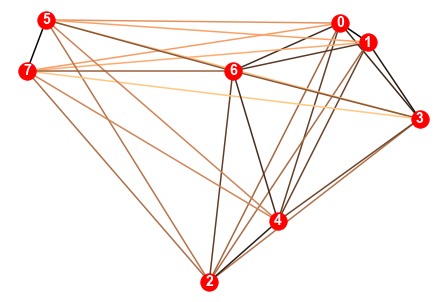

In [254]:
class GA:
    def __init__(self, graph, P=100):
        self.graph = graph
        self.P = P
        self.gene_structure = graph.vertices.copy()
        self.gene_length = graph.n
        
    def create_population(self):
        """Create an initial randomly sampled population of chromosomes P times
        Returns: 2d array of random chromosomes"""
        return [sample(self.gene_structure, self.gene_length) for i in range(self.P)]
    
    def evaluate_fitness(self, population):
        """Make use of the 'cost' function to obtain a fitness score for each chromosome
        Returns: dictionary of fitness:chromosome pairs for size of input"""
        return {cost(self.graph, chromosome): chromosome for chromosome in population}
    
    def _proportionate_selection(self, evaluated):
        """Fitness proportionate selection to obtain mating pool
        Returns: single chromosome"""
        pick = uniform(0, sum(evaluated))
        current = 0
        for fitness, chromosome in evaluated.items():
            current += fitness
            if current > pick:
                return chromosome
    
    def crossover(self, evaluated):
        mating_pool = [self._proportionate_selection(evaluated) for i in range(self.P//2)]
        children = []
        # Now apply crossover algorithm (ordered crossover in this case)
        for i in range(len(mating_pool)):
            parents = sample(mating_pool, 2)  # Randomly select two parents
            offspring_a = offspring_b = []
            parent_a, parent_b = parents[0], parents[1]
            gene_a = choice(parent_a)
            gene_b = choice(parent_b)
            for i in range(min(gene_a, gene_b), max(gene_a, gene_b)):
                offspring_a.append(parent_a[i])
            offspring_b = [gene for gene in parent_b if gene not in offspring_a]
            child = offspring_a + offspring_b
            children.append(child)
        return children
    
    def mutate(self, bred):
        mutated = []
        for i in bred:
            swap = sample(i, 2)
            i[swap[0]], i[swap[1]] = i[swap[1]], i[swap[0]]
            mutated.append(i)
        return mutated
    
    def ga_solve(self, iterations):
        population = self.create_population()
        for i in range(iterations):
            evaluated = self.evaluate_fitness(population)
            bred = self.crossover(evaluated)
            mutated = self.mutate(bred)
            population = mutated
            if i % 9 == 0:
                print(sorted(self.evaluate_fitness(population))[0])
        return self.evaluate_fitness(population)
            

G = Graph(8, "Euclidean")
draw(G)
# print(G[5][0])
# print(G.vertices)



In [255]:
ga = GA(G, P=100)
sorted(ga.ga_solve(500))


396.02976567985183
425.3947189934991
440.3165836199801
416.82432094718075
479.3789816214654
459.4853683799828
409.09813761321817
448.71452435778576
392.1795341827342
434.2469768830571
423.69603189230827
488.77906725879427
361.7864869375157
426.26428758628845
373.254662500015
436.93381233695254
364.26765428322085
410.73316355254786
446.9514899991218
445.8087138435054
419.51920479903913
386.02664277815705
445.3773953636081
450.00862721904025
461.62339056436883
385.1133874573514
315.1268324011631
420.5579756056267
453.554821441786
424.0671936389524
370.364424317636
370.05868266803554
375.47938289581964
373.254662500015
433.8657594356161
454.0991597853417
396.7346047310035
404.20019434770137
460.38158268857694
488.21384449233517
396.0112825678486
480.38613718113976
468.28181673068445
447.50511733848487
401.6694394430183
422.8822565558369
429.09121992410786
465.68343348744116
421.3823133499986
481.9949267436714
436.06184459474775
377.2386854815393
440.1160741867467
384.98397660133173
467.66

[402.1965966129147,
 419.878849472865,
 424.6449835793317,
 498.6590577598612,
 516.070570030541,
 521.0235864894125,
 523.1071326548125,
 548.5033863423042,
 554.1229365054111,
 555.3289305250725,
 557.8285355378147,
 562.9861239978147,
 565.3786680907444,
 575.0372031886945,
 619.1840372849064,
 620.1772524625643,
 625.6706211155554,
 627.933726496179,
 644.9418183230938,
 649.9455651375358,
 654.5950886427765,
 661.2819389998104,
 667.2711669463771,
 668.8587968091797,
 679.9050644520249,
 682.4810055935321,
 691.0254325884794,
 691.3444987616574,
 694.0370422074794,
 702.9277863798155,
 704.1691221593109,
 708.419244773469,
 711.0056956153293,
 715.2779196667816,
 721.0007122753747,
 729.5586898371815,
 732.5225230347755,
 735.303242705117,
 735.4584884468575,
 754.0145352528666,
 759.2104950001867,
 763.0802563455995,
 768.0924592303371,
 769.4929415669066,
 774.1734637012536,
 785.7652225652624,
 790.3433229237559,
 802.8159206039055,
 822.420636113877,
 827.2377159404812]